### ShapesGAN, our Generative Adversarial Network

First, we import our libraries. 

For the neural network part, we use pytorch as `torch`.

In [16]:
#source : https://medium.com/geekculture/introduction-to-the-gan-in-pytorch-bba920347b01

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as alt
import random

We define two networks using pytorch. There is a Discriminator and a Generator.

In [17]:
#binary classifier that determines whether data points are from the original distribution or the fake (generated) distribution
class Discriminator(torch.nn.Module):
  def __init__(self, input_dim=2, hidden_dim=28, n_layers=3):
    super(Discriminator,self).__init__()

    self.input = torch.nn.Sequential( torch.nn.Linear(input_dim, hidden_dim), torch.nn.LeakyReLU() )
    self.layers = []
    for i in range(n_layers):
      self.layers.append( torch.nn.Sequential( torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.LeakyReLU() ) )
    
    self.layers = torch.nn.ModuleList(self.layers)
    self.output = torch.nn.Sequential( torch.nn.Linear(hidden_dim, 1), torch.nn.Sigmoid() )

  def forward(self, x):
    o = self.input(x)
    for layer in self.layers:
      o = layer(o)

    o = self.output(o)
    return o
  
#Generator, takes in random noise and outputs a fake point
class Generator(torch.nn.Module):
  def __init__(self, z_dim=1, hidden_dim=28, n_layers=3, out_dim=2):
    super(Generator, self).__init__()

    self.input = torch.nn.Sequential( torch.nn.Linear(z_dim, hidden_dim), torch.nn.LeakyReLU() )
    self.layers = []
    for i in range(n_layers):
      self.layers.append( torch.nn.Sequential( torch.nn.Linear(hidden_dim, hidden_dim ), torch.nn.LeakyReLU() ) )
    
    self.layers = torch.nn.ModuleList(self.layers)
    self.output = torch.nn.Linear(hidden_dim, out_dim)

  def forward(self, x):
    o = self.input(x)
    for layer in self.layers:
      o = layer(o)

    o = self.output(o)
    return o

This function are used to create a random or true distribution of points.

In [18]:
#sample n points from [-range/2,range/2] from distribution
#dist is a single parameter function
def sample_dist(n, r, dist, mode='1d'):
  data = []

  if mode == '1d':
    x = r*(np.random.random_sample((n,))-0.5)
    
    for i in range(n):
          data.append([x[i], dist(x[i])])
  elif mode == '2d':
    for i in range(n):
      #2d dist auto samples from x,y
      out = dist()
      data.append([out[0], out[1]])

  return np.array(data)

#sample noise uniformly from -1 to 1, n vectors with dimensionality m
#m is the dimension of the latent space
def sample_noise(n, m):
  return np.random.uniform(-1., 1., size=[n, m])

We implement a variety of shape to train our model.

> Add new shapes here !

In [19]:
def parabolic_dist(x):
  return x*x

def inverse_parabolic_dist(x):
  return -(x*x)

def gauss_2d(mu=0, sigma=1):
    x = random.gauss(mu, sigma)
    y = random.gauss(mu, sigma)
    return (x, y)


def circle():
    theta = random.random() * 2 * np.pi
    x = np.cos(theta)
    y = np.sin(theta)
    return (x, y)

def square():
    r = random.random() * 4
    pos = random.random() - 0.5
    if r > 3:
      return (0.5, pos)
    if r > 2:
      return (-0.5, pos)
    if r > 1:
      return (pos, 0.5)
    else :
      return (pos, -0.5)

def heart():
    t = random.random() * 2 * np.pi;
    x = 16 * np.sin(t) * np.sin(t) * np.sin(t)
    y = 13 * np.cos(t) - 5 * np.cos(2 * t) - 2 * np.cos(3 * t) - np.cos(4 * t)
    return (x, y)

def infinity():
    t = (random.random() * 2 * np.pi) - 0.5 * np.pi;
    x = np.cos(t)
    y = np.cos(t) * np.sin(t)
    return (x, y)


This function train the generator and discriminator.

In [20]:
def train(gen, disc, optimG, optimD, distribution, criterion, fixed_noise, r=50, z_dim=10, num_epochs=30000, batch_size=32, mode='1d', device='cuda'):
  real_label = 1
  fake_label = 0

  gen_list = []
  G_losses = []
  D_losses = []
  iters = 0

  print("Training...")
  print(device)
  for epoch in range(num_epochs):
        #max log(D(x)) + log(1 - D(G(z)))
        #train on real points
        disc.zero_grad()
        
        real_points = torch.tensor( sample_dist(n=batch_size, r=r, dist=distribution, mode=mode) ).float()
        label = torch.full( (batch_size,), real_label, dtype=torch.float, device=device ).view(-1)

        output = disc(real_points).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        #train on fake points
        noise = torch.randn(batch_size, z_dim, device=device)
        fake_points = gen(noise)
        label.fill_(fake_label)
        output = disc(fake_points.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        errD = errD_real + errD_fake

        optimizerD.step()

        #max log(D(G(z)))
        gen.zero_grad()
        label.fill_(real_label)

        output = disc(fake_points).view(-1)

        errG = criterion(output, label)

        errG.backward()

        optimizerG.step()

        # Output training stats
        if iters % 50 == 0:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach().cpu()
            gen_list.append(fake)

        iters += 1

  gen_list = np.array([np.array(x) for x in gen_list])
  return gen, disc, G_losses, D_losses, gen_list

Here, the function serves to display the loss and the training process.

In [25]:
def plot_losses(G_losses, D_losses):
  #plot losses
  plt.figure()
  plt.title('Generator (green) and Discriminator (red) Losses')
  plt.plot(range(len(G_losses)), G_losses, color='green')
  plt.plot(range(len(D_losses)), D_losses, color='red')

def make_anim(gen_list, distribution, r, mode='1d'):

  if mode == '1d':
    plt.rc('animation', html='jshtml')

    def update(i):
      ax.set_xlabel('Step: {}'.format(i))
      xf = [t[0] for t in gen_list[i]]
      yf = [t[1] for t in gen_list[i]]
      ax.clear()
      ax.set_xlim((-r*2,r*2))
      ax.scatter(range(-r,r), reals, color='blue', zorder=30)
      ax.scatter(xf, yf, color='red')
      ax.set_aspect('equal')

      return ax
      
    fig, ax = plt.subplots()
    fig.set_tight_layout(False)

    reals = [distribution(x) for x in range(-r,r)]
    anim = alt.FuncAnimation(fig, update, frames=np.arange(0, gen_list.shape[0]), interval=200)

    #plot final generated pairs vs real distribution
    xf = [t[0] for t in gen_list[gen_list.shape[0]-1]]
    yf = [t[1] for t in gen_list[gen_list.shape[0]-1]]

    plt.figure()
    plt.title('Final Generator Fitting')
    plt.scatter(range(-r,r), reals, color='blue')
    plt.scatter(xf, yf, color='red', zorder=30)
    plt.axis('scaled')



  elif mode == '2d':
    plt.rc('animation', html='jshtml')

    def update(i):
      ax.set_xlabel('Step: {}'.format(i))
      xf = [t[0] for t in gen_list[i]]
      yf = [t[1] for t in gen_list[i]]
      ax.clear()
      ax.set_xlim((min(xr),max(xr)))
      ax.scatter(xr, yr, color='blue')
      ax.scatter(xf, yf, color='red', zorder=30)
      ax.set_aspect('equal')


      return ax
      

    fig, ax = plt.subplots()
    fig.set_tight_layout(False)

    reals = [distribution() for x in range(r)]
    anim = alt.FuncAnimation(fig, update, frames=np.arange(0, gen_list.shape[0]), interval=200)

    #plot final generated pairs vs real distribution
    xf = [t[0] for t in gen_list[gen_list.shape[0]-1]]
    yf = [t[1] for t in gen_list[gen_list.shape[0]-1]]

    xr = [t[0] for t in reals]
    yr = [t[1] for t in reals]

    plt.figure()
    plt.title('Final Generator Fitting')
    plt.scatter(xr, yr, color='blue')
    plt.scatter(xf, yf, color='red', zorder=30)
    plt.axis('scaled')


  return anim

This is the main part of our programm, it creates the networks and starts the learning.

> Here we choose wich distribution to launch

In [22]:
#train to fit simple function x^2
z_dim = 10
num_epochs = 30000
batch_size = 32

device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

criterion = torch.nn.BCELoss()
generator = Generator(z_dim=z_dim, hidden_dim=28, n_layers=3, out_dim=2).to(device)
discriminator = Discriminator(input_dim=2, hidden_dim=28, n_layers=3).to(device)

optimizerD = torch.optim.Adam(discriminator.parameters())
optimizerG = torch.optim.Adam(generator.parameters())
fixed_noise = torch.randn(128, z_dim, device=device)

#set the distribution to learn/train
distribution = infinity

#if distibution is 2 dimensions
r = 512 
mode = '2d'

#if distibution is 1 dimension
#r = 25
#mode = '1d'

generator, discriminator, gloss, dloss, gen_list = train(generator, discriminator, optimizerG, optimizerD, distribution, criterion, fixed_noise, r=50, z_dim=z_dim, num_epochs=num_epochs, batch_size=batch_size, device=device, mode=mode)

Training...
cpu
[0/30000]	Loss_D: 1.3862	Loss_G: 0.6773
[50/30000]	Loss_D: 1.2492	Loss_G: 0.7575
[100/30000]	Loss_D: 1.3805	Loss_G: 1.1798
[150/30000]	Loss_D: 1.3834	Loss_G: 1.6049
[200/30000]	Loss_D: 1.3729	Loss_G: 0.8226
[250/30000]	Loss_D: 1.3316	Loss_G: 0.7484
[300/30000]	Loss_D: 1.3139	Loss_G: 0.8561
[350/30000]	Loss_D: 0.7194	Loss_G: 1.0552
[400/30000]	Loss_D: 1.7098	Loss_G: 0.9460
[450/30000]	Loss_D: 1.2230	Loss_G: 0.9709
[500/30000]	Loss_D: 1.5849	Loss_G: 0.6558
[550/30000]	Loss_D: 1.3394	Loss_G: 0.8300
[600/30000]	Loss_D: 1.3852	Loss_G: 0.7159
[650/30000]	Loss_D: 1.3603	Loss_G: 0.7960
[700/30000]	Loss_D: 1.4312	Loss_G: 0.6549
[750/30000]	Loss_D: 1.3324	Loss_G: 0.7079
[800/30000]	Loss_D: 1.3728	Loss_G: 0.6820
[850/30000]	Loss_D: 1.4193	Loss_G: 0.6749
[900/30000]	Loss_D: 1.3634	Loss_G: 0.7896
[950/30000]	Loss_D: 1.3601	Loss_G: 0.7054
[1000/30000]	Loss_D: 1.3447	Loss_G: 0.6684
[1050/30000]	Loss_D: 1.1426	Loss_G: 0.8752
[1100/30000]	Loss_D: 1.3822	Loss_G: 0.9317
[1150/30000]	Loss_

Display the results :

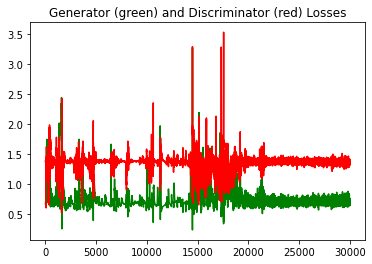

In [26]:
plot_losses(gloss, dloss)

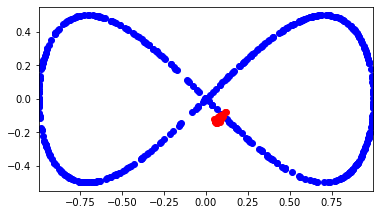

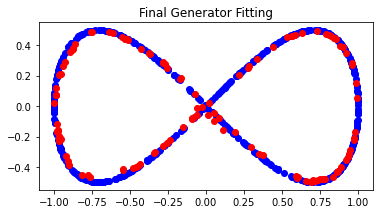

In [24]:
make_anim(gen_list, distribution, r, mode=mode)
